In [119]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

# Import the data

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data
from utils.general import beep

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

2022-03-28 11:29:18.828399: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


### Convert the data into a lower dimensionality space

In [3]:
# concatenate the train and test data together to transform it in the same space
all_data_gs = np.concatenate((train_data_gs, test_data_gs))
all_data_gs = all_data_gs.reshape(all_data_gs.shape[0], -1)
# initial dimensionality reduction using PCA to reduce the time
pca_int = PCA(n_components=50).fit_transform(all_data_gs)
# reduce to 2d using t-SNE
all_data_ld = TSNE(init='pca', learning_rate='auto', perplexity=30, n_iter=300).fit_transform(
    pca_int
)
# split the data back into train and test
train_data_ld = all_data_ld[:train_data_gs.shape[0]]
test_data_ld = all_data_ld[train_data_gs.shape[0]:]

beep()

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### Visualize the distribution of the data

In [125]:

from utils.cluster.visualize import visualize_clusters
from utils.general import beep, save_figure

# show the train data
fig, ax = visualize_clusters(heatmaps=train_data_ld, clusters=train_labels)
visualize_clusters(heatmaps=test_data_ld, clusters=test_labels, fig=fig, ax=ax, marker='v', label_prefix='test')
save_figure(fig, 'out/mnist/dataset/train_test_latent_space')

beep()

<IPython.core.display.Javascript object>

In [20]:
from DigitClassifier import DigitClassifier

# Create an instance of the classifier and train it
classifier = DigitClassifier()
classifier.fit(train_data, train_labels, epochs=3, verbose=False)
loss, acc = classifier.evaluate(test_data, test_labels)
print(f'Accuracy on test: {acc}')

beep()

313/313 [==============================] - 1s 3ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9888
Accuracy on test: 0.9887999892234802


# Filter for the misclassified data of the desired label

In [21]:
import numpy as np

# compute the predictions
predictions = classifier.predict(test_data).argmax(axis=-1)
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))
# get the mask for the misclassified data
misclassified_mask = test_labels != predictions
# find the most misclassified label
most_misclassified = sorted(list(zip(*np.unique(test_labels[misclassified_mask], return_counts=True))), key=lambda item: -item[1])[0][0]
# get the mask for the misclassified_label
chosen_label = 5
label_mask = test_labels == chosen_label
# get the complete mask
complete_mask = misclassified_mask & label_mask

print(f'Selected {len(complete_mask[complete_mask == True])}/{len(test_data)} instances for misclassified {chosen_label}')

Selected 10/10000 instances for misclassified 5


# Generate the explanations

In [37]:
from xplique.attributions import IntegratedGradients
import numpy as np
import tensorflow as tf

# generate the explanations for all the images
explainer = IntegratedGradients(classifier, steps=50)
contributions = explainer.explain(
    test_data,
    predictions_cat
).numpy()
# convert the contributions to grayscale
contributions = np.squeeze(tf.image.rgb_to_grayscale(contributions).numpy())
# filter for the positive contributions
contributions = np.ma.masked_less(np.squeeze(contributions), 0).filled(0)

beep()

### Visualize a sample of the explanations

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/1791895162.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


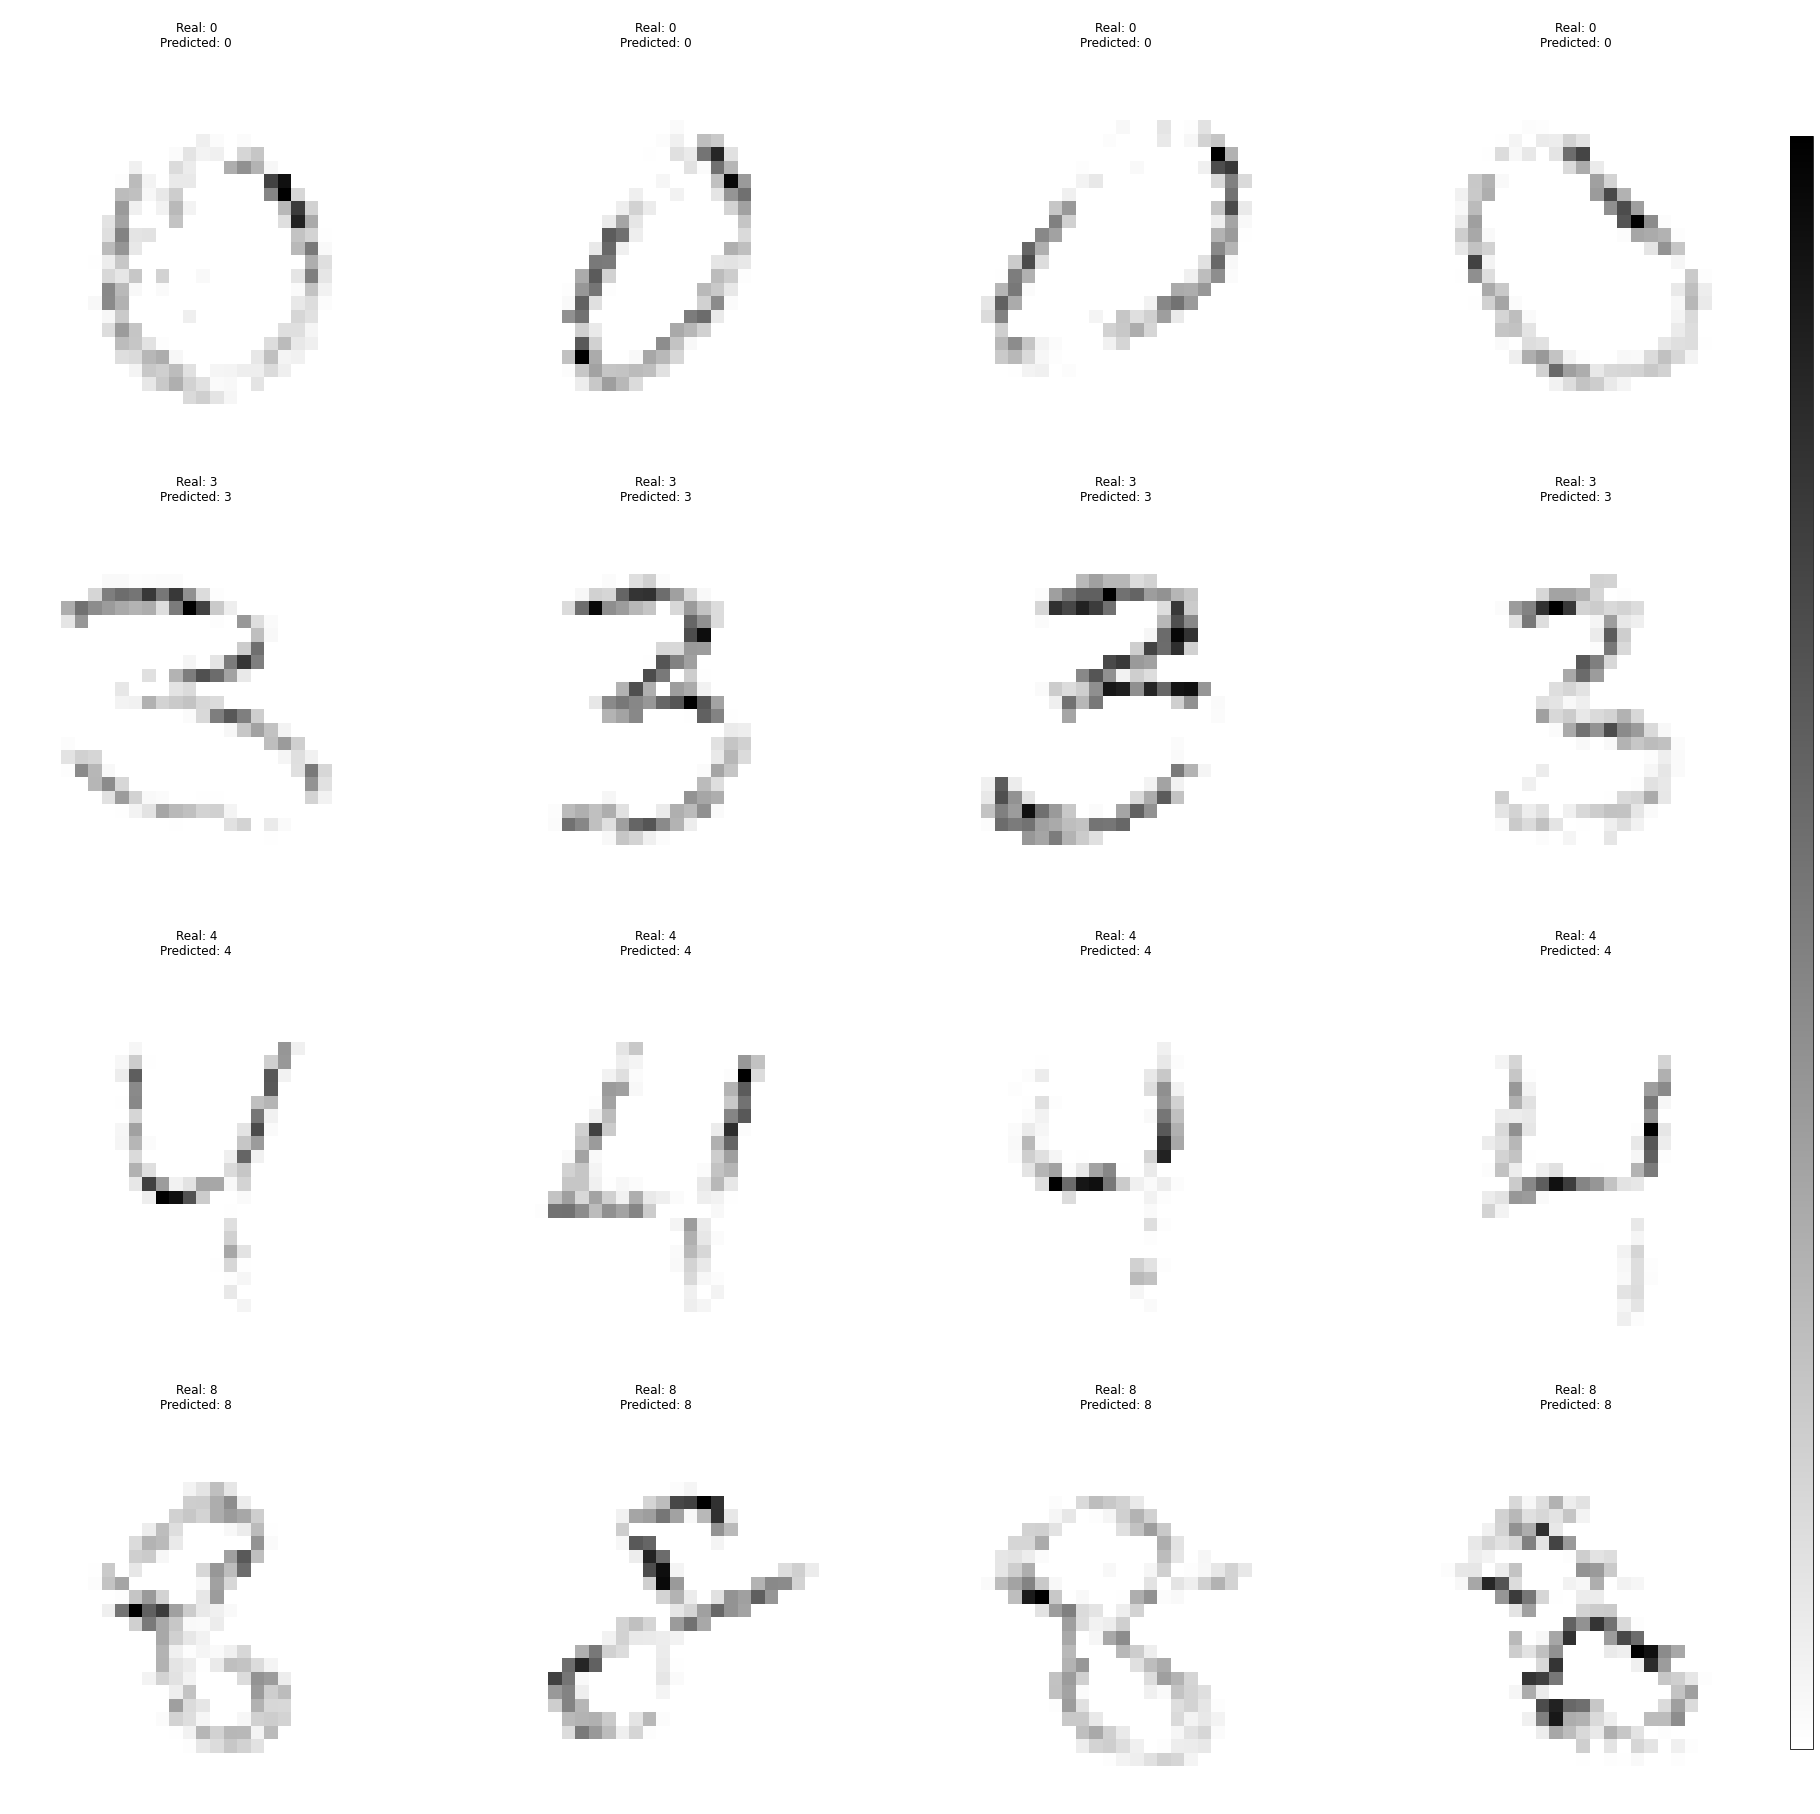

In [60]:
from utils.plotter import contributions_sample

fig, ax = contributions_sample(
    contributions, test_labels, predictions,
    explanations_count=4, labels_count=4
)

fig.show()

# export the figure

fig.savefig('../out/contributions_sample', dpi=150, transparent=True)

beep()

### Visualize the selected explanations

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/2949948278.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  selected_contributions_fig.show()


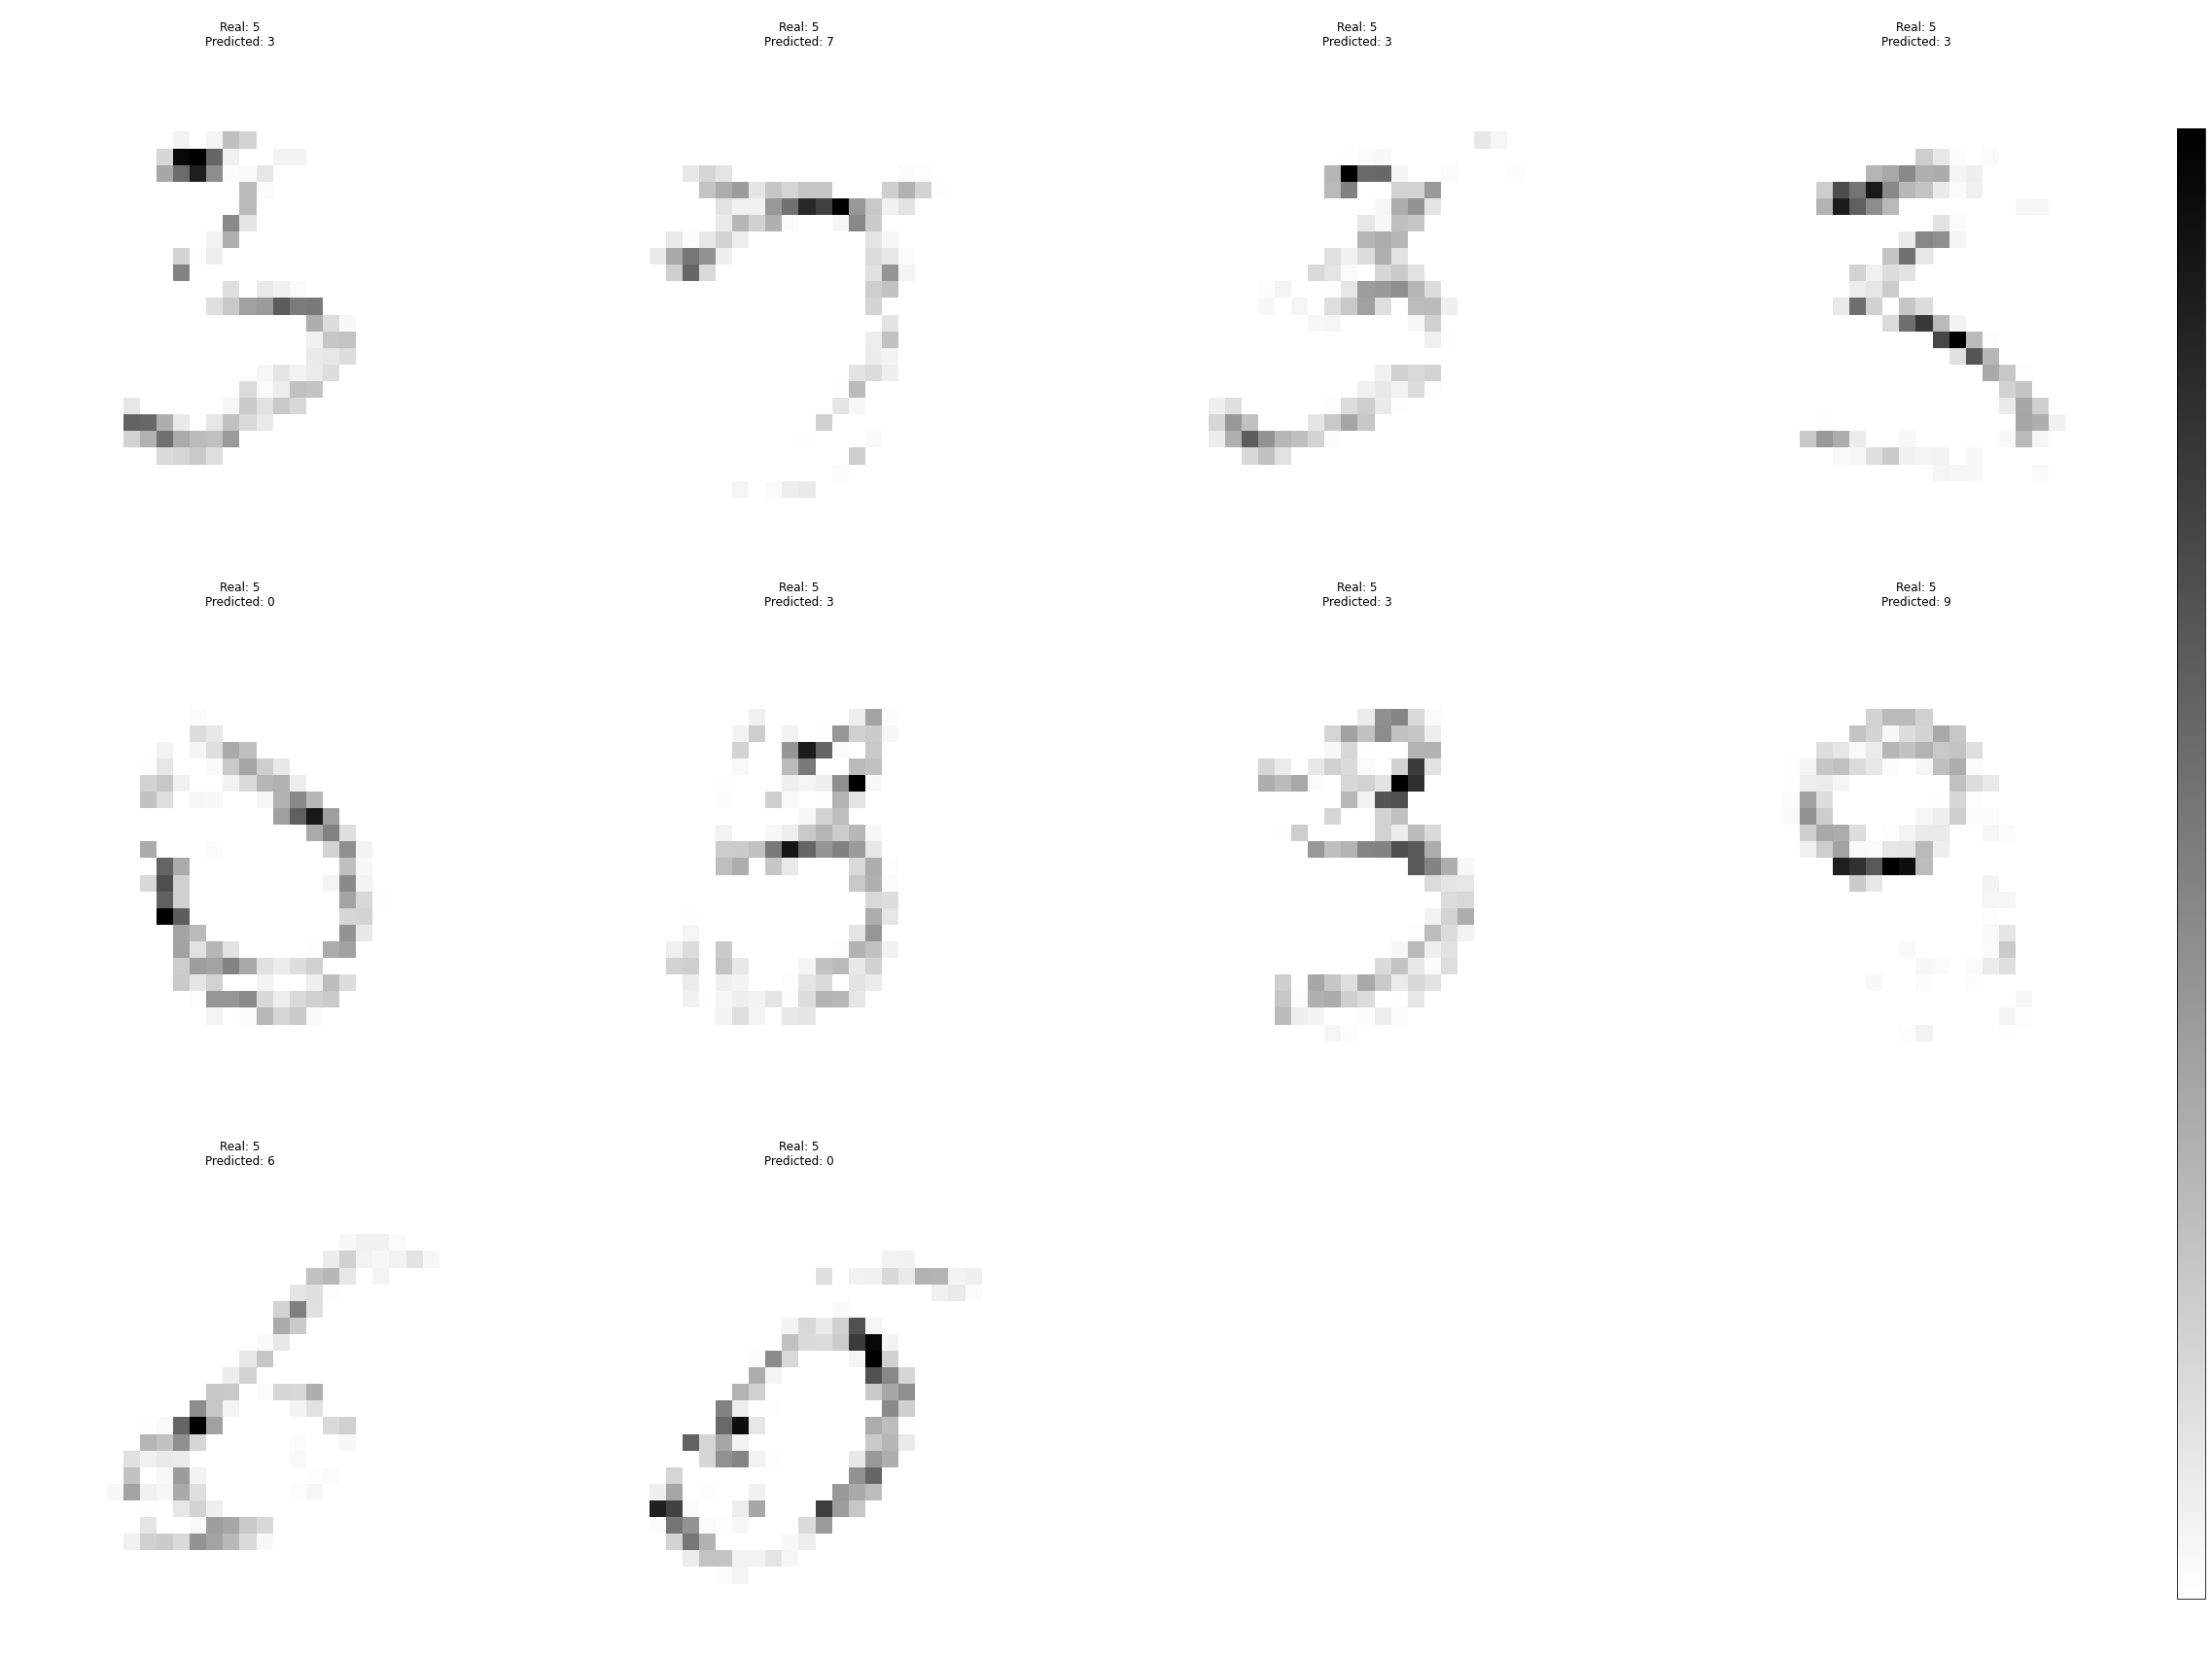

In [67]:
from utils.plotter import contributions_grid

# create the overall figure
selected_contributions_fig, selected_contributions_ax = contributions_grid(
    contributions=contributions[complete_mask],
    real_labels=test_labels[complete_mask],
    predicted_labels=predictions[complete_mask],
)
selected_contributions_fig.show()
selected_contributions_fig.savefig('../out/contributions_misclassified', dpi=150, transparent=True)

beep()

### Visualize the distribution of the heatmaps

In [68]:
# initial dimensionality reduction using PCA to reduce the time
pca_int = PCA(n_components=50).fit_transform(
    contributions.reshape(contributions.shape[0], -1)
)
# reduce to 2d using t-SNE
contributions_ld = TSNE(init='pca', learning_rate='auto', perplexity=30, n_iter=300).fit_transform(
    pca_int
)

beep()

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


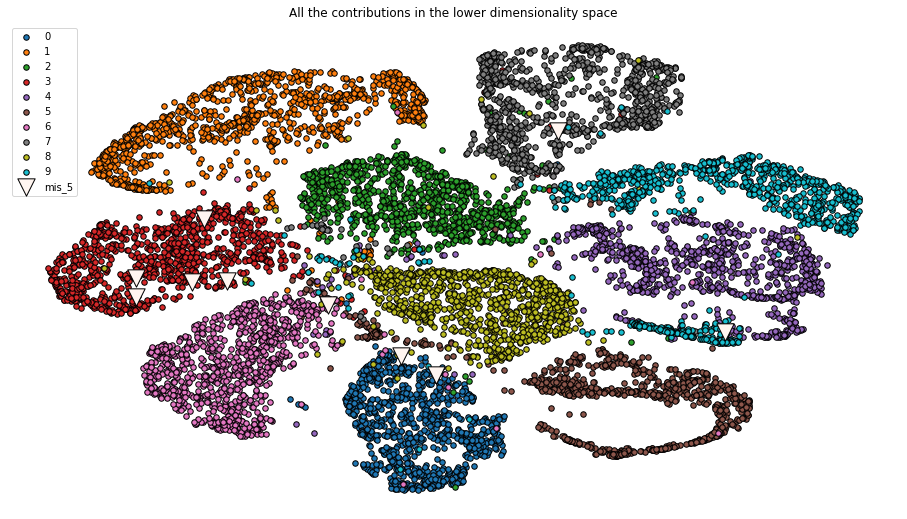

In [73]:
# show all the heatmaps
contributions_fig, contributions_ax = visualize_clusters(contributions_ld, test_labels)
# highlight the misclassified heatmaps
visualize_clusters(
    contributions_ld[complete_mask], test_labels[complete_mask],
    marker='v', size=300, fig=contributions_fig, ax=contributions_ax,
    label_prefix='mis',
    cmap='Reds'
)
contributions_ax.set_title('All the contributions in the lower dimensionality space')
contributions_fig.savefig('../out/contributions_all_latent_space.png', dpi=150, transparent=True)

# Compute the distance matrix

In [74]:
from utils.image_similarity.intensity_based import euclidean_distance
from utils.cluster.preprocessing import distance_matrix

# compute the distance matrix for the contributions
dist_matrix = distance_matrix(contributions[complete_mask], dist_func=euclidean_distance)

### Visualize the distance matrix

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/1234893614.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  dist_matrix_fig.show()


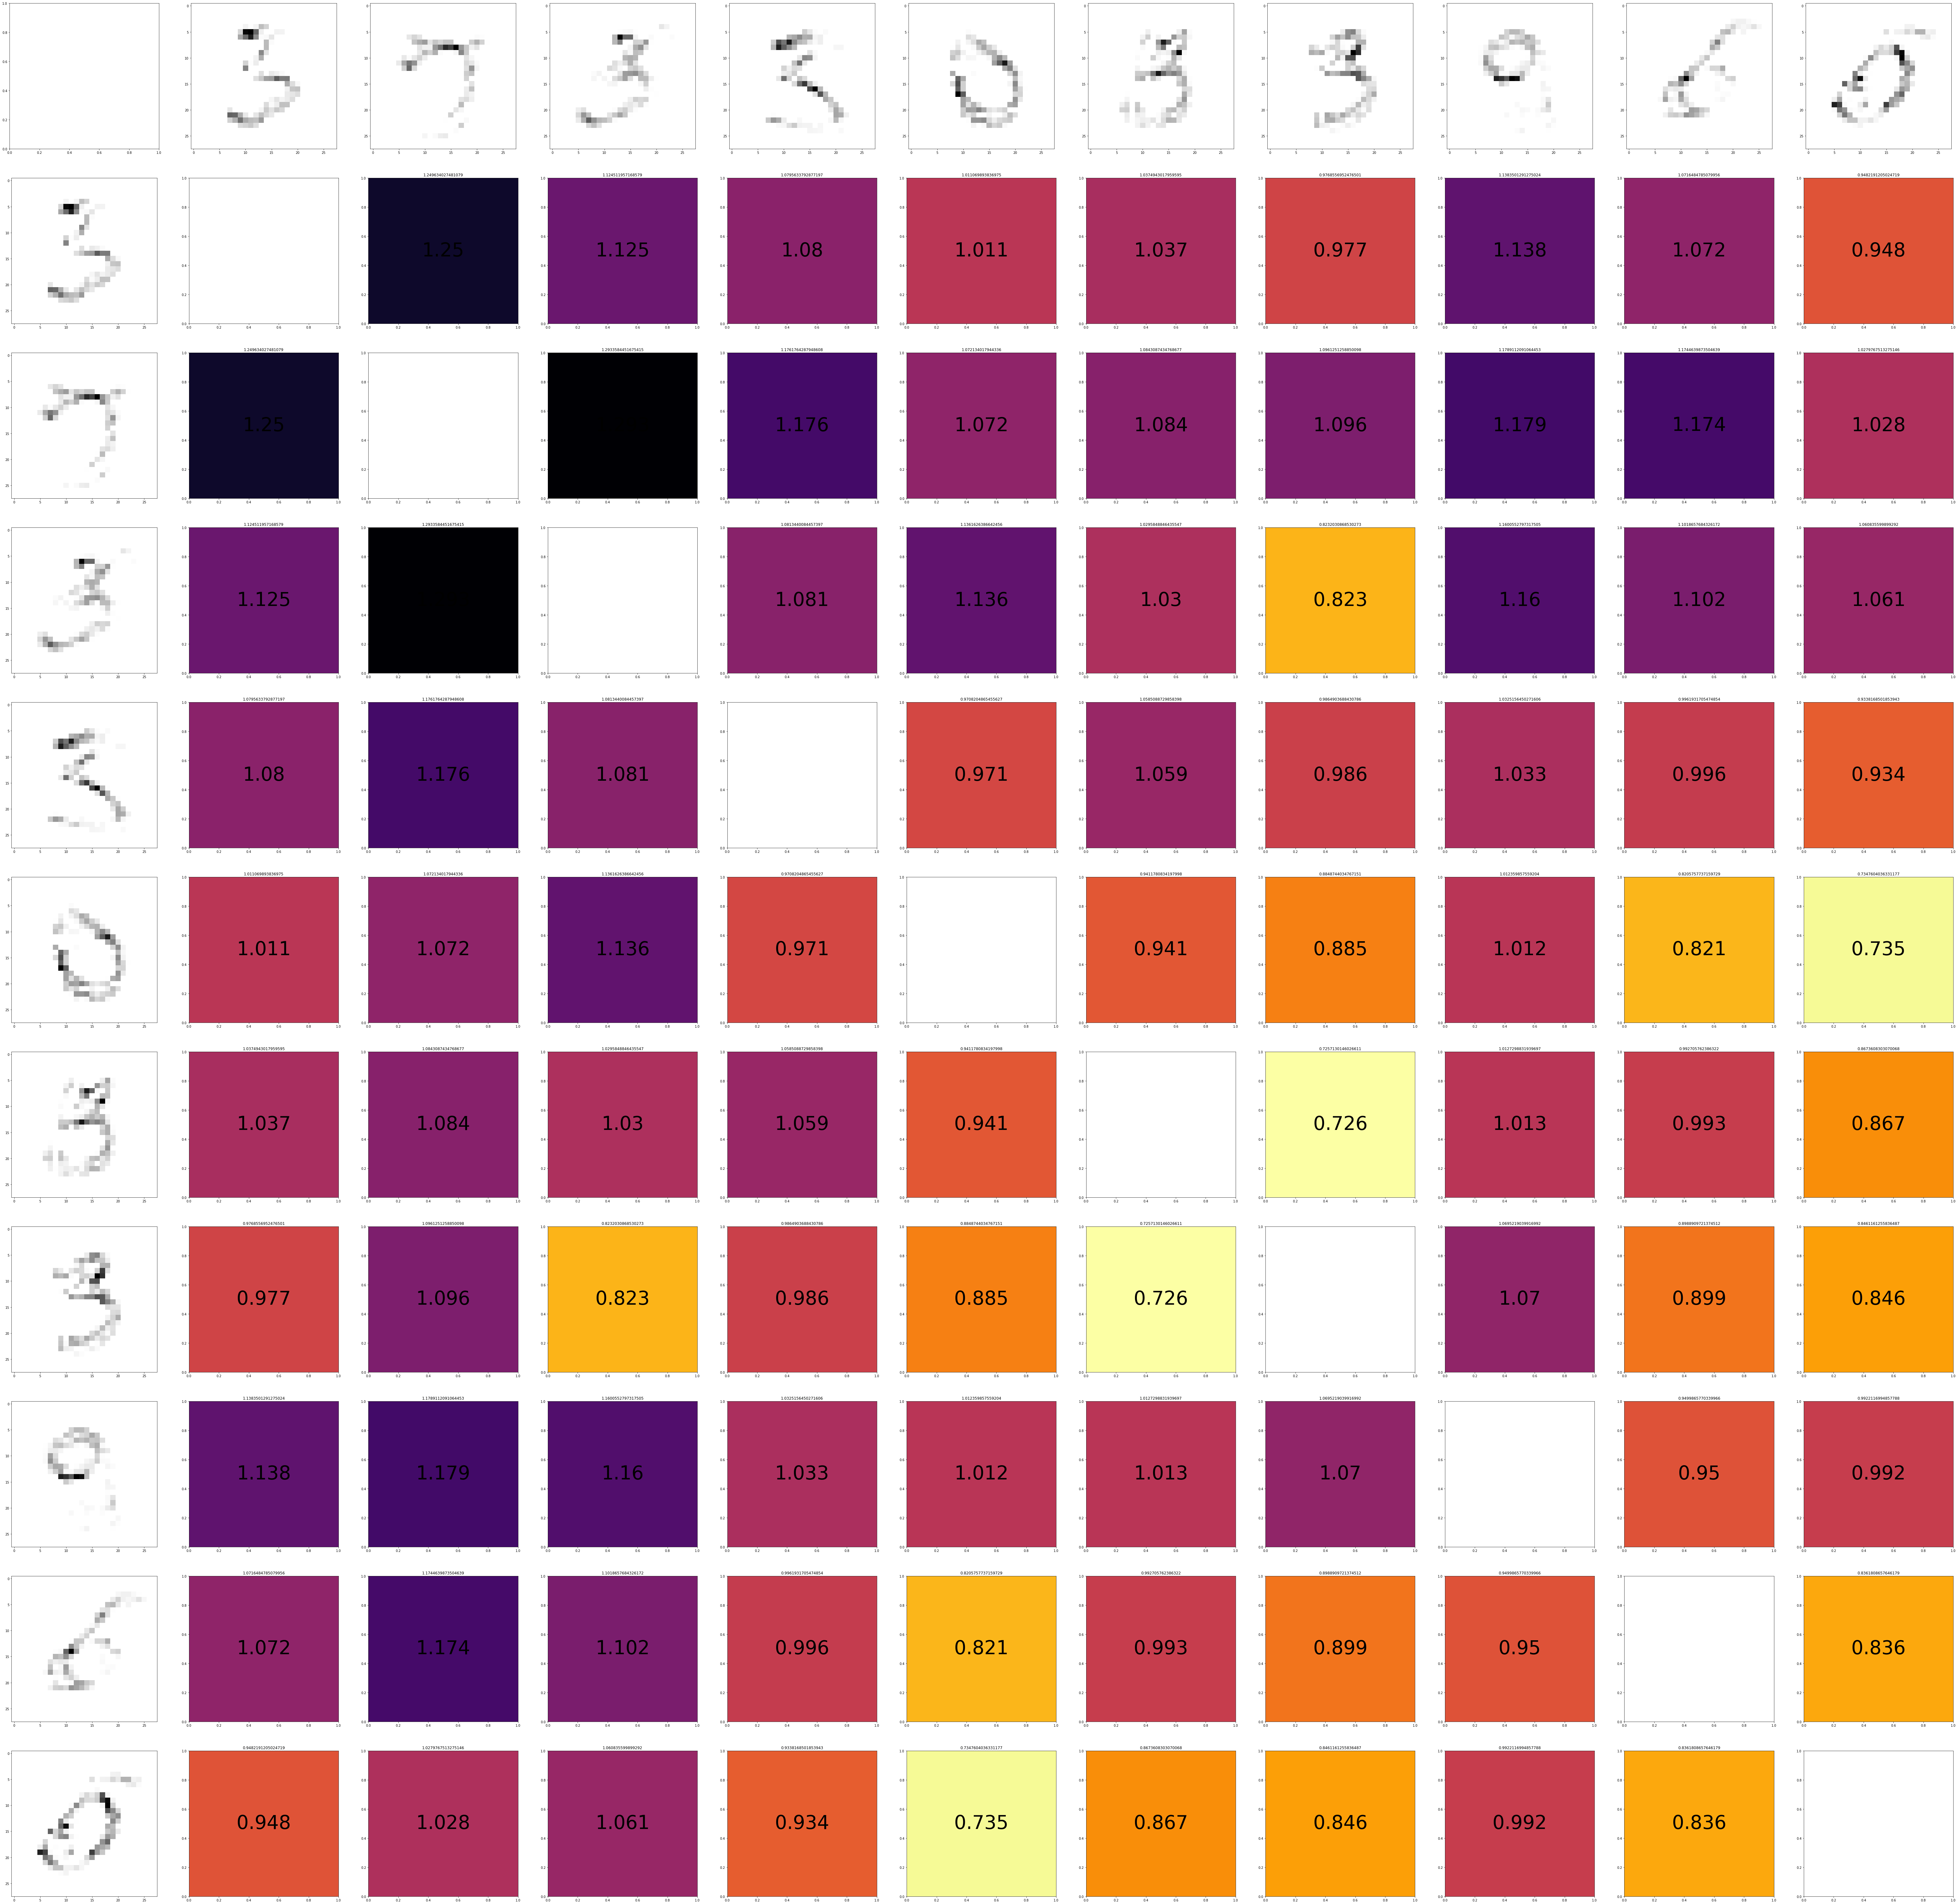

In [75]:
from utils.cluster.visualize import visualize_distance_matrix

dist_matrix_fig, dist_matrix_ax = visualize_distance_matrix(
    distance_matrix=dist_matrix,
    heatmaps=contributions[complete_mask]
)
dist_matrix_fig.show()

dist_matrix_fig.savefig('../out/distance_matrix_visual', dpi=150, transparent=False)

beep()

# Cluster using the distance matrix

### Find the point of maximum curvature for epsilon

The point of maximum curvature is 0.8747101087234735


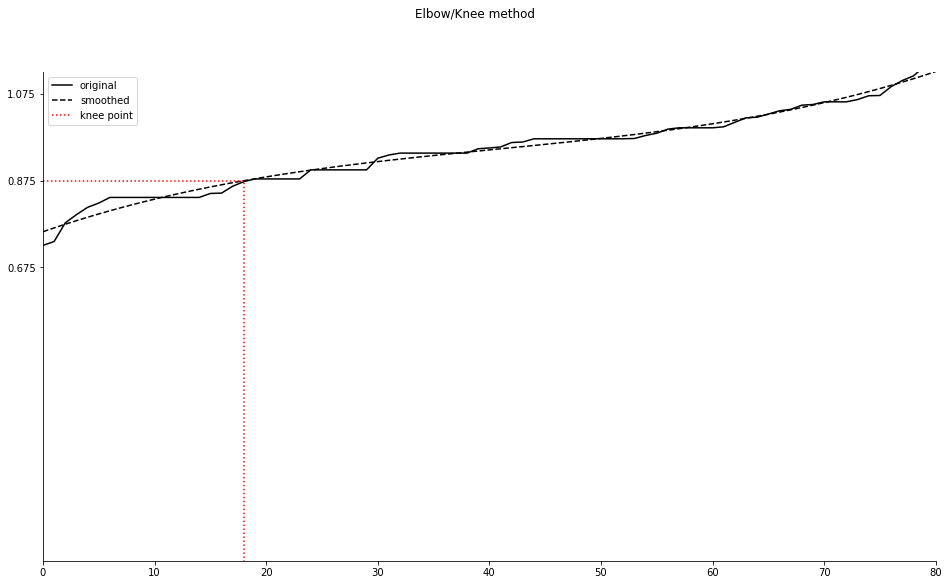

In [76]:
from utils.image_similarity.stats import get_elbow_point

elbow_point, fig, _ = get_elbow_point(dist_matrix, smoothing_factor=.1, plot=True)
print(f'The point of maximum curvature is {elbow_point}')
fig.suptitle('Elbow/Knee method')
fig.savefig('../out/elbow_point.png', dpi=150, transparent=True)

### Compute the clusters

In [99]:

from sklearn.cluster import AffinityPropagation

dm_clusters = AffinityPropagation(affinity='precomputed').fit_predict(dist_matrix)

##### Visualize the clusters

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


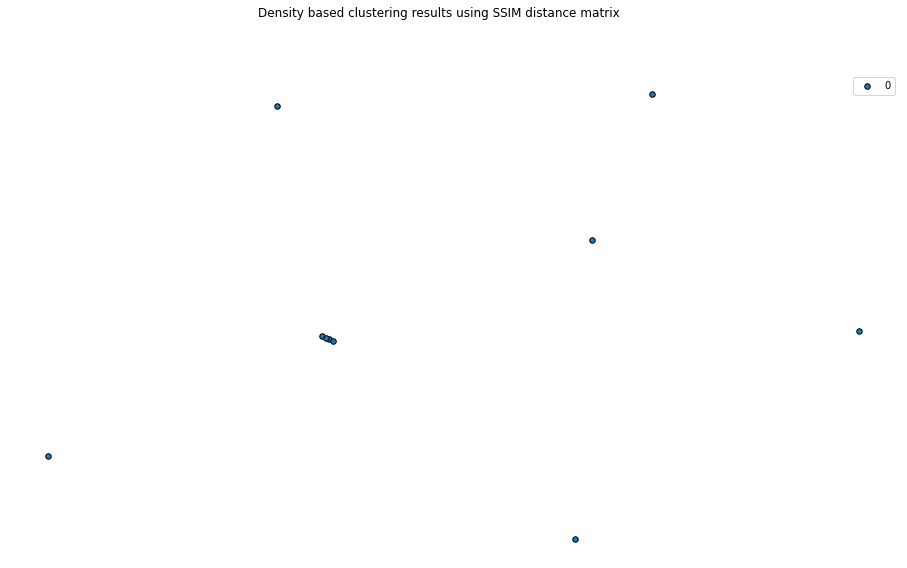

In [87]:
from utils.cluster.visualize import visualize_clusters

fig, ax = visualize_clusters(
    heatmaps=TSNE(perplexity=.1).fit_transform(contributions[complete_mask].reshape(
        contributions[complete_mask].shape[0], -1
    )),
    clusters=dm_clusters
)
fig.suptitle('Density based clustering results using SSIM distance matrix')

fig.savefig('../out/db_clusters_dist_matrx_points', dpi=150, transparent=True)

TypeError: 'AxesSubplot' object is not subscriptable

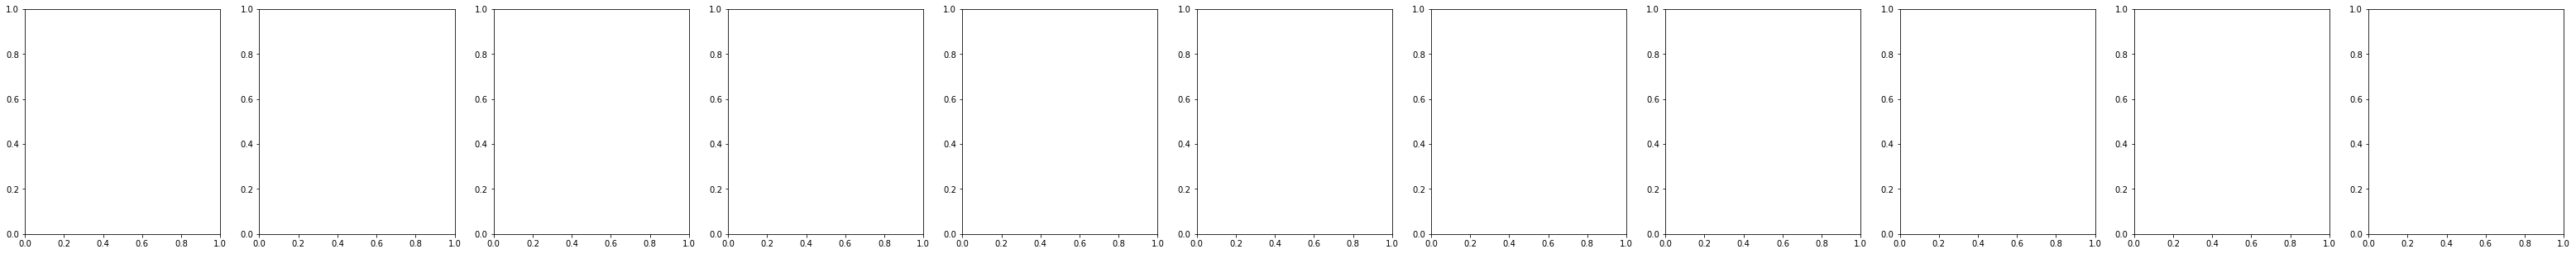

In [88]:
from utils.cluster.visualize import visualize_clusters_images

fig, ax = visualize_clusters_images(clusters=dm_clusters, heatmaps=contributions[complete_mask])
fig.suptitle('Density based clusters using SSIM distance matrix')

fig.savefig('../out/db_clusters_dist_matrx_images', dpi=150, transparent=True)

beep()

# Cluster in the latent space

### CLuster in the complete latent space

In [100]:

from sklearn.metrics import silhouette_score

# optimal = find_optimal_configuration(
#     models=[
#         DBSCAN(metric='euclidean', eps=elbow_point, min_samples=min_samples)
#         for min_samples in range(2, 10)
#     ],
#     data=contributions_ld[complete_mask],
#     verbose=True
# )

lso_clusters = AffinityPropagation().fit_predict(contributions_ld[complete_mask])

# compute the silhouette score for the clusters
print('Silhouette score: ', silhouette_score(
    contributions_ld[complete_mask],
    lso_clusters
))

Silhouette score:  0.4688576


/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/2398667691.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


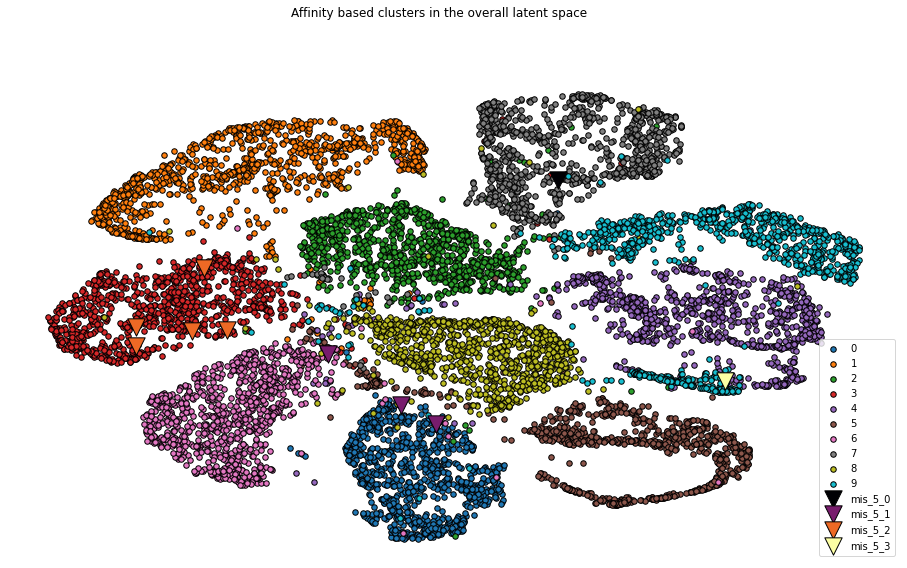

In [103]:
# show all the heatmaps
fig, ax = visualize_clusters(contributions_ld, test_labels)
# highlight the misclassified heatmaps
visualize_clusters(
    contributions_ld[complete_mask], lso_clusters,
    marker='v', size=300, fig=fig, ax=ax,
    label_prefix='mis_5', cmap='inferno'
)
fig.suptitle('Affinity based clusters in the overall latent space')
fig.show()

fig.savefig('../out/affinity_based_overall_latent', dpi=150, transparent=True)

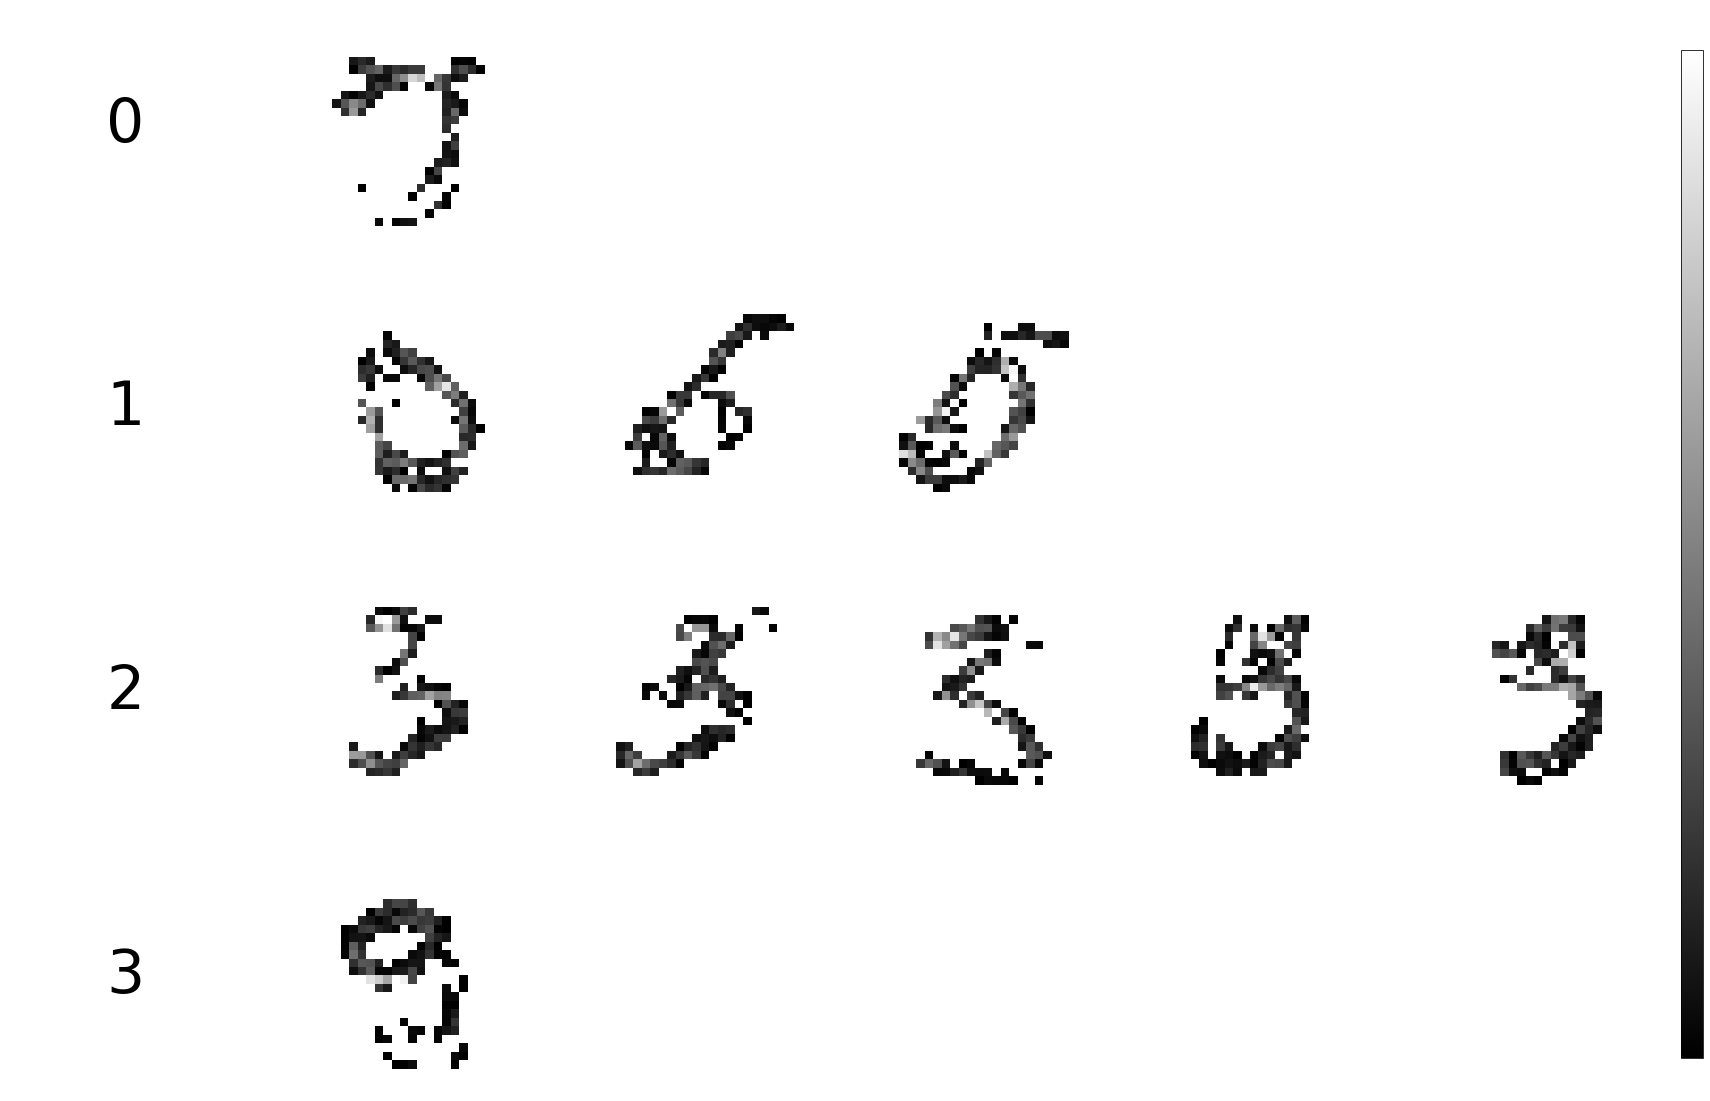

In [107]:
from utils.cluster.visualize import visualize_clusters_images

fig, ax = visualize_clusters_images(clusters=lso_clusters, heatmaps=contributions[complete_mask])

# fig.savefig('../out/db_clusters_dist_matrx_images', dpi=150, transparent=True)

beep()

### Cluster in the selected latent space

In [108]:
# transform the contributions in the latent space
lss_contributions = TSNE(perplexity=.1).fit_transform(contributions[complete_mask].reshape(
    contributions[complete_mask].shape[0],
    -1
))
# cluster the contributions
lss_clusters = AffinityPropagation().fit_predict(lss_contributions)
# compute the silhouette score for the clusters
silhouette_score = silhouette_score(lss_contributions, lss_clusters)
print('Silhouette score: ', silhouette_score)

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Silhouette score:  0.27565232


/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/4113870519.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


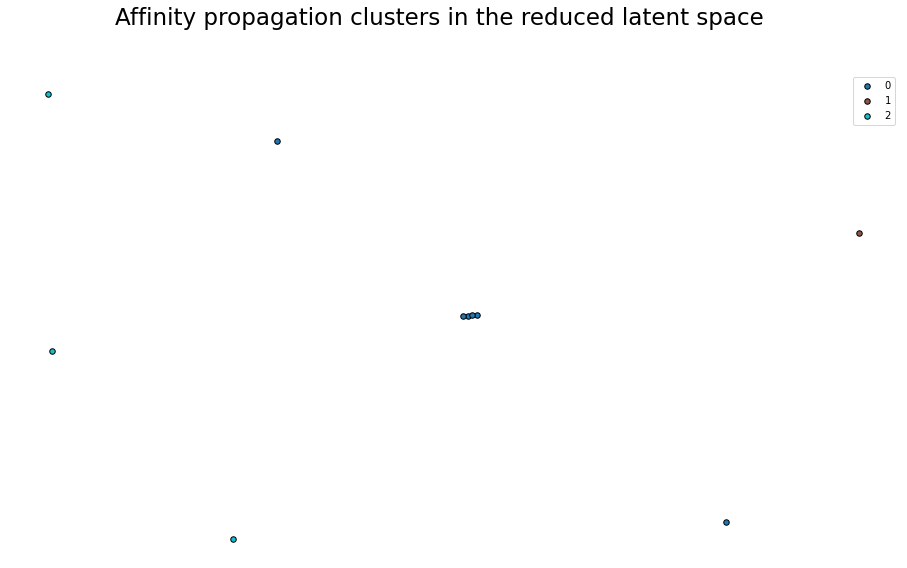

In [109]:
fig, ax = visualize_clusters(
    clusters=lss_clusters, heatmaps=lss_contributions,
)
fig.suptitle('Affinity propagation clusters in the reduced latent space', size=23)
fig.show()

fig.savefig('../out/cluster_points_affinity_propagation_reduced_latent_space')

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/540624708.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


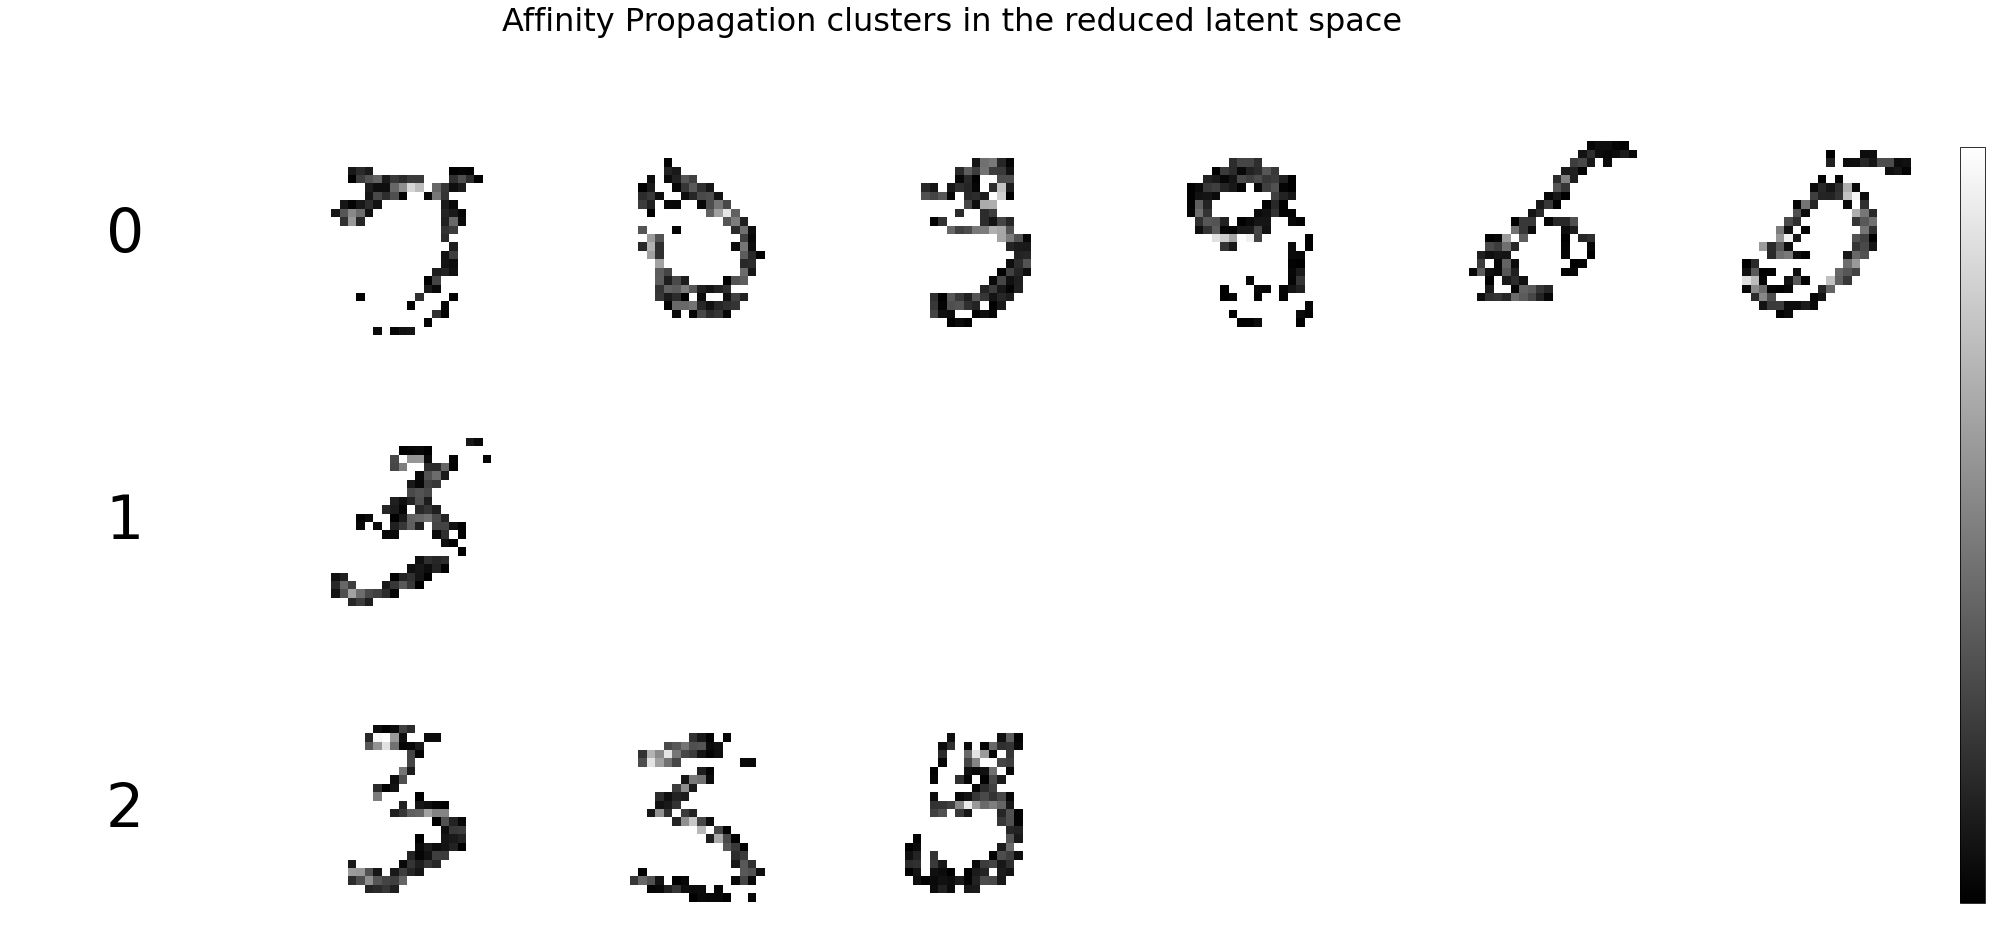

In [110]:
fig, ax = visualize_clusters_images(clusters=lss_clusters, heatmaps=contributions[complete_mask])
fig.suptitle('Affinity Propagation clusters in the reduced latent space', size=32)
fig.show()

fig.savefig('../out/cluster_images_affinity_propagation_reduced_latent_space', dpi=150, transparent=True)